In [ ]:
# Reyhan Suisanto
# 2301872980

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

Pertama, load dataset. Kemudian buat plt untuk mengetahui sedikit gambaran tentang dataset

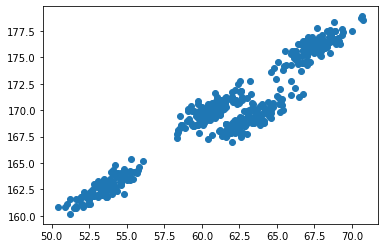

In [ ]:
dataset = pd.read_csv("UAS_ML2021_DATASET02.csv")

x1 = dataset['Atribut_01']
x2 = dataset['Atribut_02']

plt.scatter(x1,x2)
plt.show()

Saya menggunakan scaler agar value dari dataset di normalize sehingga lebih mudah di proses

In [ ]:
scaler = StandardScaler()
data = scaler.fit_transform(dataset)

Kemudian saya menggunakan library KMeans untuk membuat silhoutte method dan nanti untuk menunjukkan silhoutte score

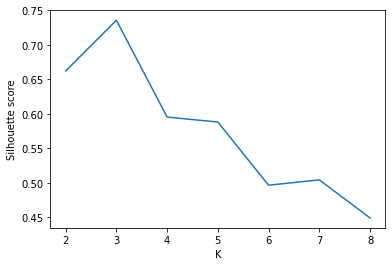

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []

for num_clusters in range_n_clusters:
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(data)
 cluster_labels = kmeans.labels_
 # silhouette score
 silhouette_avg.append(silhouette_score(data, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg)
plt.xlabel('K')
plt.ylabel('Silhouette score') 
plt.show()

Bisa dilihat dari grafik diatas bahwa pucuk ada di angka 3, maka dari itu terdapat 3 cluster dalam dataset ini. Setelah itu saya cari silhoutte score nya dan score tertinggi ada di k=3

In [ ]:
for n_clusters in range_n_clusters:
    cluster = KMeans (n_clusters=n_clusters).fit(data)
    pred = cluster.predict(data)
    center = cluster.cluster_centers_

    # Silhoutte Score
    score = silhouette_score (data, pred, metric='euclidean')
    print (f"For K = {n_clusters}, score is {score}")

For K = 2, score is 0.6621705527181878
For K = 3, score is 0.7356847709879415
For K = 4, score is 0.595065322092602
For K = 5, score is 0.5880894311427806
For K = 6, score is 0.5250379447371764
For K = 7, score is 0.4385350703092437
For K = 8, score is 0.4464360448302465


Sekarang saya mencari center dari setiap cluster untuk nanti digunakan ke mu/mean

In [ ]:
kmeans = KMeans(n_clusters=3).fit(data)
centre_k = kmeans.cluster_centers_
print(centre_k)

[[ 0.12696481  0.02289726]
 [ 1.197698    1.32922733]
 [-1.47732521 -1.40637377]]


Lalu dibawah adalah step pertama untuk GMM

In [ ]:
row = data.shape[0]
columns = data.shape[1]

# Initialize mean, sigma, and phi
mu = centre_k
sigma = [np.cov(data.T) for _ in range(3)]
phi = np.full(shape=3, fill_value=row/3)

# Calculate initial value of log likelihood
likelihood = np.zeros((row, 3))

# Responsibility (resp) shows the probability of every single item belong to cluster 0 or cluster 1 (only 2 cluster)
resp = np.zeros((row, 3))

Step kedua yaitu E-Step adalah untuk mencari log likelihood nya

In [ ]:
for i in range(3):
    likelihood[:,i] = multivariate_normal.pdf(data, mu[i], sigma[i], allow_singular=True)
    resp[:, i] = phi[i] * likelihood[:,i]

# Rumus log likelihood
loglikelihood = np.sum(np.log(np.sum(resp, axis = 1)))

resp = resp / resp.sum(axis = 1, keepdims = 1)

print(loglikelihood)

2251.383916675718


Kemudian M-step yaitu untuk update mean, sigma, dan phi agar kemudian bisa digunakan lagi untuk mengubah log likelihoodnya sampai dapat konvergen

In [ ]:
for i in range(3):
    weight = resp[:, [i]]
    total_weight = weight.sum()
    mu[i] = (data * weight).sum(axis=0) / total_weight
    sigma[i] = np.cov(data.T, aweights=(weight/total_weight).flatten(), bias=True)

phi = resp.mean(axis=0)

# Hasil mean, sigma, dan phi yang baru
print("Updated Means :", mu)
print("Updated Covariances :", sigma)
print("Updated Phi :", phi)

Updated Means : [[ 0.16364495  0.02489242]
 [ 0.72590159  0.84743819]
 [-1.01771883 -0.94525372]]
Updated Covariances : [array([[0.57147388, 0.50520591],
       [0.50520591, 0.54417897]]), array([[0.45646697, 0.44634824],
       [0.44634824, 0.48968424]]), array([[0.56927666, 0.53889915],
       [0.53889915, 0.54895277]])]
Updated Phi : [0.4135852  0.30346298 0.28295182]


Kemudian saya membuat sebuah looping sebanyak 100 iterasi agar saya bisa lihat iterasi ke berapa yang konvergen (log likelihoodnya sama)

In [ ]:
for j in range(100):

  # E-step to print the new log likelihood
  for i in range(3):
      likelihood[:,i] = multivariate_normal.pdf(data, mu[i],sigma[i], allow_singular=True)
      resp[:, i] = phi[i] * likelihood[:,i]

  loglikelihood = np.sum(np.log(np.sum(resp, axis = 1)))

  # normalize over all possible cluster 
  resp = resp / resp.sum(axis = 1, keepdims = 1)

  # Update mean, sigma, and phi using M-step again
  for i in range(3):
      weight = resp[:, [i]]
      total_weight = weight.sum()
      mu[i] = (data * weight).sum(axis=0) / total_weight
      sigma[i] = np.cov(data.T, aweights=(weight/total_weight).flatten(), bias=True)

  phi = resp.mean(axis=0)
  print(f'Iteration {j}: {loglikelihood}')

Iteration 0: -720.5981006680241
Iteration 1: -651.829916292004
Iteration 2: -579.5435557238889
Iteration 3: -523.9338387758022
Iteration 4: -492.1851983949066
Iteration 5: -461.4794985993161
Iteration 6: -441.7982369732335
Iteration 7: -436.6801565163179
Iteration 8: -428.6338650289479
Iteration 9: -415.61604169312994
Iteration 10: -400.803938018582
Iteration 11: -393.5655288629051
Iteration 12: -392.71757184145474
Iteration 13: -392.68200015080174
Iteration 14: -392.67959178957955
Iteration 15: -392.6793998874447
Iteration 16: -392.6793844457228
Iteration 17: -392.6793832032962
Iteration 18: -392.67938310335114
Iteration 19: -392.67938309531166
Iteration 20: -392.6793830946649
Iteration 21: -392.6793830946127
Iteration 22: -392.67938309460885
Iteration 23: -392.67938309460845
Iteration 24: -392.6793830946085
Iteration 25: -392.6793830946085
Iteration 26: -392.6793830946084
Iteration 27: -392.6793830946084
Iteration 28: -392.6793830946084
Iteration 29: -392.67938309460845
Iteration 30:

Bisa dilihat dari hasil diatas bahwa ada log likelihood yang konvergen. Kemudian saya menggunakan library GaussianMixture untuk mencari log likelihood yang paling optimal

In [ ]:
GMM = GaussianMixture (n_components=3).fit(data)
labels = GMM.predict (data)
optimal = GMM.score(data)
optimal

-0.7853616483298623

Dan terakhir, saya menunjukkan cluster yang sudah terbagi dengan baik dan benar

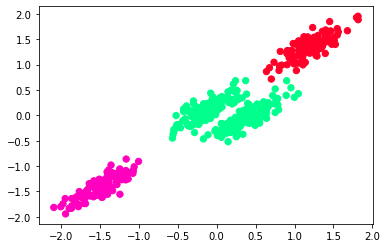

In [ ]:
plt.scatter (data[:, 0], data[:, 1], c = labels, s = 40, cmap='gist_rainbow')